## Natural Language Processing with Python 

***

In this project, We will use NLP and machine learning models to build a **spam filter to classify Spam vs Non-Spam messages.**

The project includes:
    - Exploratory Data analysis and Data Visualization
    - Text Pre-Processing
    - Vectorization
    - Model Training and Prediction [Naive Bayes Classifier]
    - Model Evaluation
    
### Data:

The dataset is from [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The file we are using contains a collection of more than 5 thousand SMS phone messages

##### Import Libraries

In [20]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [21]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [22]:
print(len(messages))

5574


In [23]:
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

##### Printing the first 5 messages

In [24]:
for msg_no,msg in enumerate(messages[:5]):
    print(msg_no,msg)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though




Due to the spacing we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. 

Using pandas to read the messages into a dataframe with labels "ham" and "spam"

In [25]:
messages_df = pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['label','message'])

In [26]:
messages_df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysis

Let's explore some details about ham vs spam messages using "Groupby" function

In [27]:
messages_df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's make a new column to detect how long the text messages are:

In [28]:
messages_df['length']=messages_df['message'].apply(len)

In [29]:
messages_df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

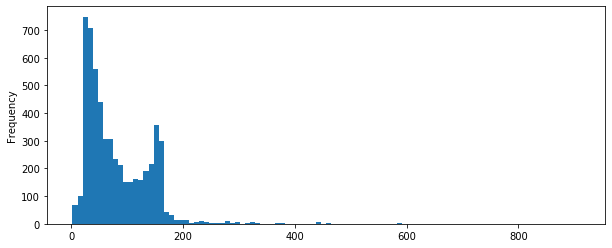

In [30]:
messages_df['length'].plot.hist(bins=100,figsize=(10,4))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002056AED6EF0>,
      dtype=object)

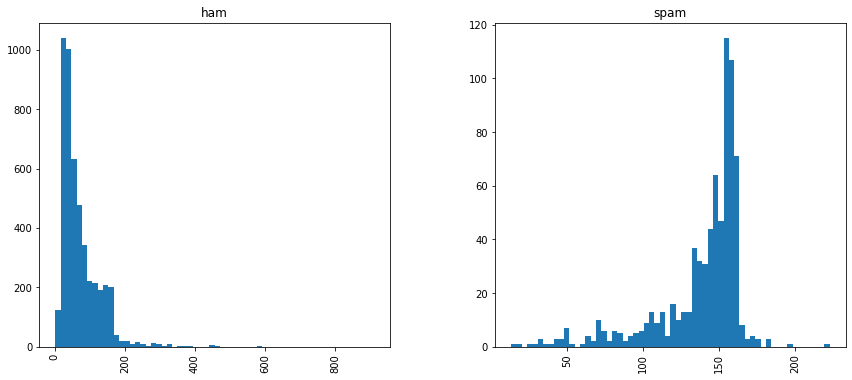

In [31]:
messages_df.hist(column='length',by='label',bins=60,figsize=(14,6))

Spam messages seems to have more characters,most of the spam messages have 50+ characters, we can consider this as one of the features to distinguish ham vs spam messages

### Text Pre-Processing  

Let's use the bag-of-words approach, where each unique word in a text will be represented by one number. Let's convert the raw messages (sequence of characters) into vectors (sequences of numbers).

Tokenization is the process of converting normal text into a list of words/tokens.

In [32]:
import string
from nltk.corpus import stopwords

In [33]:
def process_text(message):
    """
    1. Remove Punctuation
    2. Remove Stop Words
    3. Return Clean text
    """
    nopunc = [char for char in message if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word not in stopwords.words('english')]
    

Let's test the function

In [34]:
mess1 = "Hi... How are you? This is a test message"

In [35]:
process_text(mess1)

['Hi', 'How', 'This', 'test', 'message']

### Vectorization

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

- Count how many times does a word occur in each message (Known as term frequency)

- Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

- Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
bow_transformer = CountVectorizer(analyzer=process_text).fit(messages_df['message'])

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new bow_transformer:


In [38]:
mess2 = messages_df['message'][3]
print(mess2)

U dun say so early hor... U c already then say...


In [39]:
bow1 = bow_transformer.transform([mess2])
print(bow1)
print(bow1.shape)

  (0, 4221)	2
  (0, 4821)	1
  (0, 5453)	1
  (0, 6396)	1
  (0, 6414)	1
  (0, 7378)	1
  (0, 9746)	2
(1, 11617)


From above results, we can that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once.


Let's check the repeated words in the message4:

In [40]:
print(bow_transformer.get_feature_names()[4221])
print(bow_transformer.get_feature_names()[9746])

U
say


Let's Transform the entire dataframe of messages

In [41]:
messages_bow = bow_transformer.transform(messages_df['message'])

In [42]:
print('Shape of sparse matrix: ',messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of sparse matrix:  (5572, 11617)
Amount of Non-Zero occurences:  56024


### TF-IDF

TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. 

TF: Term Frequency, which measures how frequently a term occurs in a document. 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer

In [44]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

Let's check tfidf for the 4th message:

In [45]:
print(tfidf_transformer.transform(bow1))

  (0, 9746)	0.5385626262927564
  (0, 7378)	0.4389365653379857
  (0, 6414)	0.3187216892949149
  (0, 6396)	0.29953799723697416
  (0, 5453)	0.29729957405868723
  (0, 4821)	0.26619801906087187
  (0, 4221)	0.40832589933384067


Let's convert entire dataframe into tf-idf corpus:

In [46]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11617)


## Training a Model

With messages as vector, we can finally train our classifier. Let's use **Naive Bayes Classifier** model:

In [47]:
from sklearn.naive_bayes import MultinomialNB

In [52]:
from sklearn.model_selection import train_test_split

Let's split the data into train and test set to measure the model performance

In [54]:
X = messages_df['message']
y = messages_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

#### Data Pipeline

To train our model on test_set we need to transform it again. Instead of doing the previous steps again, we will create a data pipeline for the process. This will allow us to set up all the transformations that we will do to the data for future use.

In [55]:
from sklearn.pipeline import Pipeline

In [57]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=process_text)), # strings to token integer counts
    ('tfidf',TfidfTransformer()), #integer counts to weighted TF-IDF scores
    ('classifier',MultinomialNB()) #train with naive Bayes Classifier
])

Let's train our data

In [58]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x000002056B26D378>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [59]:
predictions = pipeline.predict(X_test)

## Evaluating the Model

In [60]:
from sklearn.metrics import classification_report

In [61]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1475
        spam       1.00      0.65      0.79       197

    accuracy                           0.96      1672
   macro avg       0.98      0.82      0.88      1672
weighted avg       0.96      0.96      0.95      1672



## The End